# Descriptive Analysis
This notebook is for making first models using dataset ES_0

#### Objective:
1. make models progressively adding information as covariables:
    1. mean and sd
    2. ols - hour and month dummies
    3. ols - hour transformed and month dummies 
    4. ols - hour transformed and month information as sin and cos

### Proposal notebook structure:
1. Imports and adding non-stocastic covariables
2. Model making: for each model
    1. Create X from each of the models
    1. metrics
    2. errors graphs
    3. acf and pacf errors

## 1. Importing and adding basic covariables

In [92]:
from jh_utils.data.sql.connection import create_string_connection
from jh_utils.data.pandas.sql import get_sql_table

from sqlalchemy import create_engine
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import dotenv_values
env = dotenv_values('../../.env')

figsize = (20,7)
figsize2 = (20,5)

In [93]:
# getting the data
con = create_string_connection(database=env['db'], 
                  user=env['user'],
                  password=env['pass'], 
                  host=env['host1'],
                  port=env['port'])
con = create_engine(con)
query = 'select * from datasets."ES_0"'
df = get_sql_table(query, con)

In [94]:
## adding covariables
df['hour'] = df.date_time.dt.hour
df['month'] = df.date_time.dt.month
df['year'] = df.date_time.dt.year
df['day_of_year'] = df.date_time.dt.day_of_year
df['weekofyear'] = df.date_time.dt.weekofyear

## transforming start hour in 9, to use hour**3, some models are hierarchical so is necessary to keep hour**2 
df['hour_9'] = df['hour'].apply(lambda x: (x-9)%24)
df['hour_9**2'] = df['hour_9']**2
df['hour_9**3'] = df['hour_9']**3

/home/joaoholz/miniconda3/envs/weather/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [95]:
## setting target variables to be easy to call later
y1 = 'A612 - precipitacao total, horario (mm)'
y2 = 'A612 - temperatura maxima na hora ant. (aut) (°c)'
y3 = 'A612 - temperatura minima na hora ant. (aut) (°c)'

# Linear Regression Models

In [96]:
from statsmodels.regression.linear_model import OLS
from jh_utils.data.pandas.preprocessing import make_dummies
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from jh_utils.ml.time_series.covariables import create_sincos_year_array

In [97]:
## metrics
from sklearn.metrics import mean_absolute_error, median_absolute_error
def mean_abs_deviation(y):
    return ((y - y.mean()).apply(abs)).mean()

def median_abs_deviation(y):
    return ((y - y.median()).apply(abs)).median()

In [98]:
def create_metrics(y_test,y_pred):
    ret = {}
    ret['mean abs deviation'] = mean_abs_deviation(y_test)
    ret['mean_absolute_error'] = mean_absolute_error(y_test, y_pred)
    ret['median abs deviation'] = median_abs_deviation(y_test)
    ret['median absolute error'] = median_absolute_error(y_test,y_pred)
    return ret

In [99]:
def ols_model(x,y):
    x_train, x_test = x[df_model.date_time<'01-01-2018'], x[df_model.date_time>='01-01-2018']
    y_train, y_test = y[df_model.date_time<'01-01-2018'], y[df_model.date_time>='01-01-2018']
    model = OLS(y_train,x_train)
    fit = model.fit()
    y_pred = fit.predict(x_test)    
    metrics = create_metrics(y_test,y_pred)
    return y_pred, fit, model, metrics

## Declaring x and y to be used

In [140]:
df_model = df[df.date_time < '01-01-2020']
df_model = pd.concat([df_model,create_sincos_year_array(df_model.shape[0], df_model.date_time.max(), df_model.date_time.min(), n_days_in_year=366)],axis=1)
_y_ = df_model[['A612 - precipitacao total, horario (mm)','A612 - temperatura minima na hora ant. (aut) (°c)','A612 - temperatura minima na hora ant. (aut) (°c)']]

In [146]:
x = df_model.iloc[:,-10:]
x['hour'] = df_model.hour

In [148]:
x = x.drop(['day_of_year','weekofyear','year'],axis=1)

## 2. Linear Regression with just dummies

In [155]:
x_dummy = pd.concat([x,make_dummies(x['hour'])],axis=1)
x_dummy = pd.concat([x_dummy,make_dummies(x['month'])],axis=1)
x_dummy.drop(['month', 'hour_9', 'hour_9**2', 'hour_9**3', 'hour', 'sin_year', 'cos_year'],axis=1,inplace=True)
x_dummy['intercept'] = 1

In [160]:
y_pred, fit, model, metrics = ols_model(x_dummy,_y_.iloc[:,2])

In [161]:
metrics

{'mean abs deviation': 2.907495302172599,
 'mean_absolute_error': 1.6612933887418018,
 'median abs deviation': 2.400000000000002,
 'median absolute error': 1.3935025540001593}

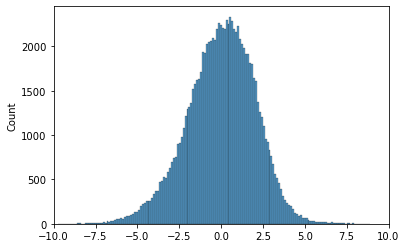

In [162]:
plt.xlim(-10,10)
_ = sns.histplot(fit.resid)

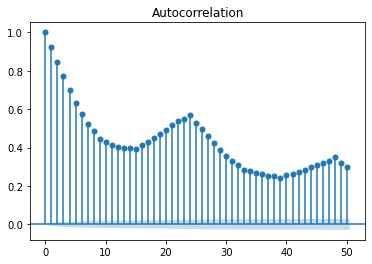

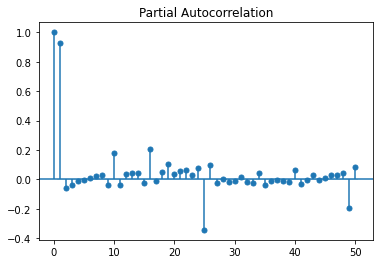

In [163]:
_ = plot_acf(fit.resid)
_ = plot_pacf(fit.resid)

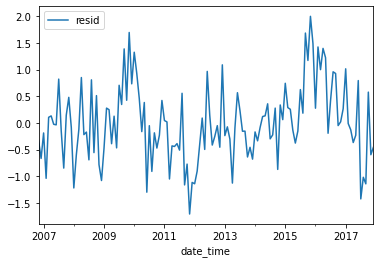

In [164]:
df_plot = pd.DataFrame(df_model.date_time[:len(fit.resid)])
df_plot['resid'] = fit.resid
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()
_ = df_plot.plot()

## 3. Linear Regression month dummies + hour_9**3

In [167]:
x_hour_9 = pd.concat([x,make_dummies(x['month'])],axis=1)
x_hour_9.drop(['month', 'hour', 'sin_year', 'cos_year'],axis=1,inplace=True)
x_hour_9['intercept'] = 1

In [169]:
y_pred, fit, model, metrics = ols_model(x_hour_9,_y_.iloc[:,2])

In [170]:
metrics

{'mean abs deviation': 2.907495302172599,
 'mean_absolute_error': 1.6822048040370292,
 'median abs deviation': 2.400000000000002,
 'median absolute error': 1.398029803702002}

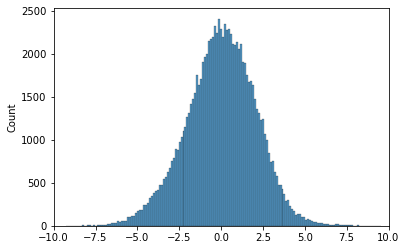

In [171]:
plt.xlim(-10,10)
_ = sns.histplot(fit.resid)

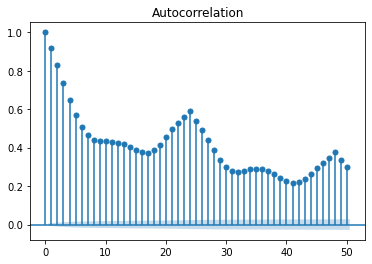

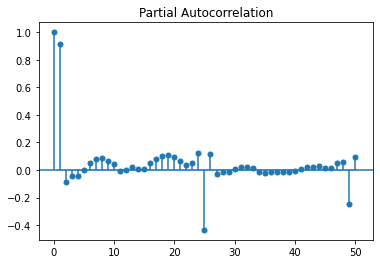

In [172]:
_ = plot_acf(fit.resid)
_ = plot_pacf(fit.resid)

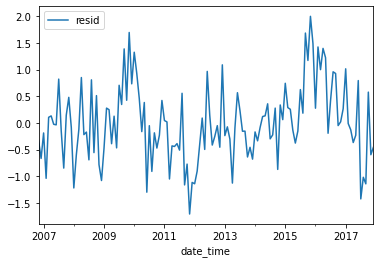

In [173]:
df_plot = pd.DataFrame(df_model.date_time[:len(fit.resid)])
df_plot['resid'] = fit.resid
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()
_ = df_plot.plot()

## 4. Linear Regression year sin cos + hour_9**3

In [184]:
x_no_dummies = df_model.loc[:,['hour_9', 'hour_9**2', 'hour_9**3','sin_year', 'cos_year']]
x_no_dummies['intercept'] = 1

In [186]:
y_pred, fit, model, metrics = ols_model(x_no_dummies,_y_.iloc[:,2])

In [187]:
metrics

{'mean abs deviation': 2.907495302172599,
 'mean_absolute_error': 1.6830082075507595,
 'median abs deviation': 2.400000000000002,
 'median absolute error': 1.3878511822166057}

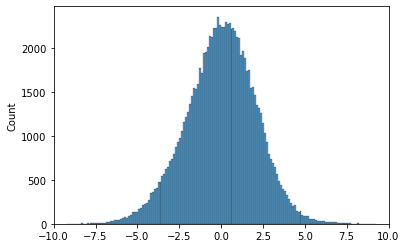

In [188]:
plt.xlim(-10,10)
_ = sns.histplot(fit.resid)

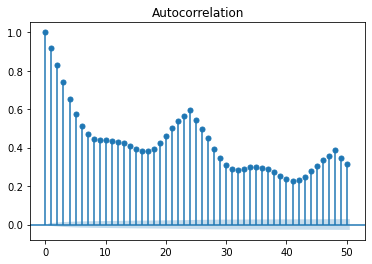

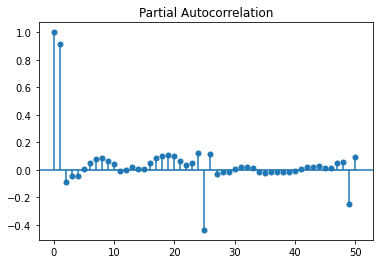

In [189]:
_ = plot_acf(fit.resid)
_ = plot_pacf(fit.resid)

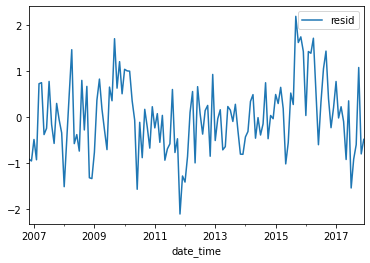

In [190]:
df_plot = pd.DataFrame(df_model.date_time[:len(fit.resid)])
df_plot['resid'] = fit.resid
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()
_ = df_plot.plot()